In [1]:
import matplotlib.pyplot as plt #It is good to import matplotlib before librosa otherwise there will be a 
#error that matplotlib raise an attribute error that there is no module 'pyplot'in matplotlib
#from matplotlib import pyplot as plt

import librosa
import librosa.display as ld
import pandas as pd
import numpy as np
import seaborn as sns
import json
import IPython.display as ipd
import playsound as playsound
import os

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
filepath='../../../../mir_datasets/irmas/IRMAS-TrainingData/'
folders=os.listdir(filepath)

In [3]:
folders

['cla', 'voi', 'flu', 'org', 'vio', 'gac', 'cel', 'gel', 'tru', 'pia', 'sax']

In [4]:
def augment_data(y,sr):
    """
    this function is for audio augmentation ito increase the data size
    
    Paramters
    ===================
    y= audio time series which is returned after loading the audio file
    sr= sample rate of the audio sample
    """
    aug_data=[]

    # Add white noise to audio file
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise
    
    # Shift pitch of audio file
    pitch_shifted = librosa.effects.pitch_shift(y, sr, n_steps=2)

    # Stretch audio file
    stretched = librosa.effects.time_stretch(y, rate=1)

    #Combine augmented audio files into single array
    for i in range(0,len(y)):
        mean=(y_noise[i]+pitch_shifted[i]+stretched[i])/3
        aug_data.append(mean)

    augmented_audio=np.array(aug_data)
    return augmented_audio

In [5]:
def mfcc_musinst(folders,filepath):
    """
    spectrogram from the chosen folders
    Parameters
    ------------
    folders = input of list of folders to be created for nr. of musical instruments in the same directory as folder
    filepath = filepath from where WAV files need to be taken 
    """
    #to check if there is matching number of folders for filepath of musical instruments
    #assert len(folders) == len(filepath)
    all_mfcc_list = []
    mel_list=[]
    classes=[]
    
    for i,folder in enumerate(folders):
        files = os.listdir(filepath+folder+'/')

        print(f'No. of wav files in {folder} is {len(files)}')
        for file in files:
            ygram,sr=librosa.load(filepath+folder+'/'+file,sr=44100)
            aug_gram=augment_data(ygram,sr)
            Xgram = librosa.feature.melspectrogram(y=ygram,sr=44100,n_fft=2048,hop_length=512,n_mels=129)
            X_aug_gram = librosa.feature.melspectrogram(y=aug_gram,sr=44100,n_fft=2048,hop_length=512,n_mels=129)
            X_gram_=np.mean(Xgram,1)
            X_aug_gram_=np.mean(X_aug_gram,1)
            mel_list.append(X_gram_)
            mel_list.append(X_aug_gram_)
            Xgram_mfcc=librosa.feature.mfcc(S=librosa.power_to_db(Xgram),n_mfcc=129)
            X_aug_gram_mfcc=librosa.feature.mfcc(S=librosa.power_to_db(X_aug_gram),n_mfcc=129)
            X_mfcc=np.mean(Xgram_mfcc,1)
            X_aug_mfcc=np.mean(X_aug_gram_mfcc,1)
            all_mfcc_list.append(X_mfcc)
            all_mfcc_list.append(X_aug_mfcc)
            classes.append(i)
            classes.append(i)
            
    return all_mfcc_list,mel_list,classes

In [6]:
a,b,c=mfcc_musinst(folders,filepath)

No. of wav files in cla is 505
No. of wav files in voi is 778
No. of wav files in flu is 451
No. of wav files in org is 682
No. of wav files in vio is 580
No. of wav files in gac is 637
No. of wav files in cel is 388
No. of wav files in gel is 760
No. of wav files in tru is 577
No. of wav files in pia is 721
No. of wav files in sax is 626


In [300]:
from sklearn.preprocessing import StandardScaler
scaler_mfcc=StandardScaler()
scaler_mel=StandardScaler()
mfcc_set=np.array(a)
mel_set=np.array(b)
class_set=np.array(c)
np.savetxt("mfcc_set.csv",mfcc_set, delimiter=",")
np.savetxt("mel_set.csv",mel_set, delimiter=",")
np.savetxt("class_set.csv",class_set,delimiter=",")


mfcc_scaled=scaler_mfcc.fit_transform(mfcc_set)
mel_scaled=scaler_mel.fit_transform(mel_set)

NameError: name 'a' is not defined

In [85]:
mfcc_set=pd.read_csv('mfcc_set.csv',sep=',',header=None)
mel_set=pd.read_csv('mel_set.csv',sep=',',header=None)
class_set=pd.read_csv('class_set.csv',sep=',',header=None)
mfcc_set=np.array(mfcc_set)
mel_set=np.array(mel_set)
class_set=np.array(class_set[0])
class_set=class_set.astype(dtype=int)
from sklearn.preprocessing import StandardScaler
scaler_mfcc=StandardScaler()
scaler_mel=StandardScaler()
mfcc_scaled=scaler_mfcc.fit_transform(mfcc_set)
mel_scaled=scaler_mel.fit_transform(mel_set)

In [86]:
mfcc_set.shape,mel_set.shape,class_set.shape

((13410, 129), (13410, 129), (13410,))

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

In [88]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits= splitter.split(mfcc_scaled,class_set)
for train_index,test_index in splits:
    train_set = mfcc_scaled[train_index]
    test_set = mfcc_scaled[test_index]
    train_classes = class_set[train_index]
    test_classes = class_set[test_index]

In [89]:
# Create Train and Test Set
splitter_ = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_= splitter.split(mel_scaled,class_set)
for train_index,test_index in splits_:
    train_set_ = mel_scaled[train_index]
    test_set_ = mel_scaled[test_index]
    train_classes_ = class_set[train_index]
    test_classes_ = class_set[test_index]

In [90]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (10728, 129)
test_set shape: (2682, 129)
train_classes shape: (10728,)
test_classes shape: (2682,)


In [91]:
print("train_set shape:",train_set_.shape)
print("test_set shape:",test_set_.shape)
print("train_classes shape:",train_classes_.shape)
print("test_classes shape:",test_classes_.shape)

train_set shape: (10728, 129)
test_set shape: (2682, 129)
train_classes shape: (10728,)
test_classes shape: (2682,)


In [92]:
# KNN Classifier
n_neighbors=1
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)


In [93]:


# kNN
model_knn.fit(train_set, train_classes)



KNeighborsClassifier(n_neighbors=1)

In [94]:
predicted_labels = model_knn.predict(test_set)

In [95]:
predicted_labels.shape

(2682,)

In [96]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])



Recall:  [0.86138614 0.95819936 0.86666667 0.94505495 0.8362069  0.89411765
 0.81290323 0.90789474 0.9047619  0.87543253 0.852     ]
Precision:  [0.94565217 0.85632184 0.93413174 0.94160584 0.86995516 0.85714286
 0.9        0.91089109 0.84274194 0.8877193  0.87295082]
F1-Score:  [0.9015544  0.90440061 0.89913545 0.94332724 0.85274725 0.87523992
 0.85423729 0.90939044 0.87265136 0.8815331  0.86234818]
Accuracy: 0.89  , 2385
Number of samples: 2682


In [161]:
import itertools
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




In [162]:
g=pd.DataFrame({'y_true': test_classes[0:], 'y_pred':predicted_labels[0:]})

In [163]:
g

,y_true,y_pred
0,0,0
1,6,6
2,10,10
3,9,9
4,3,3
...,...,...
2677,10,10
2678,3,3
2679,9,7
2680,9,9


In [164]:
cf=confusion_matrix(test_classes, predicted_labels)

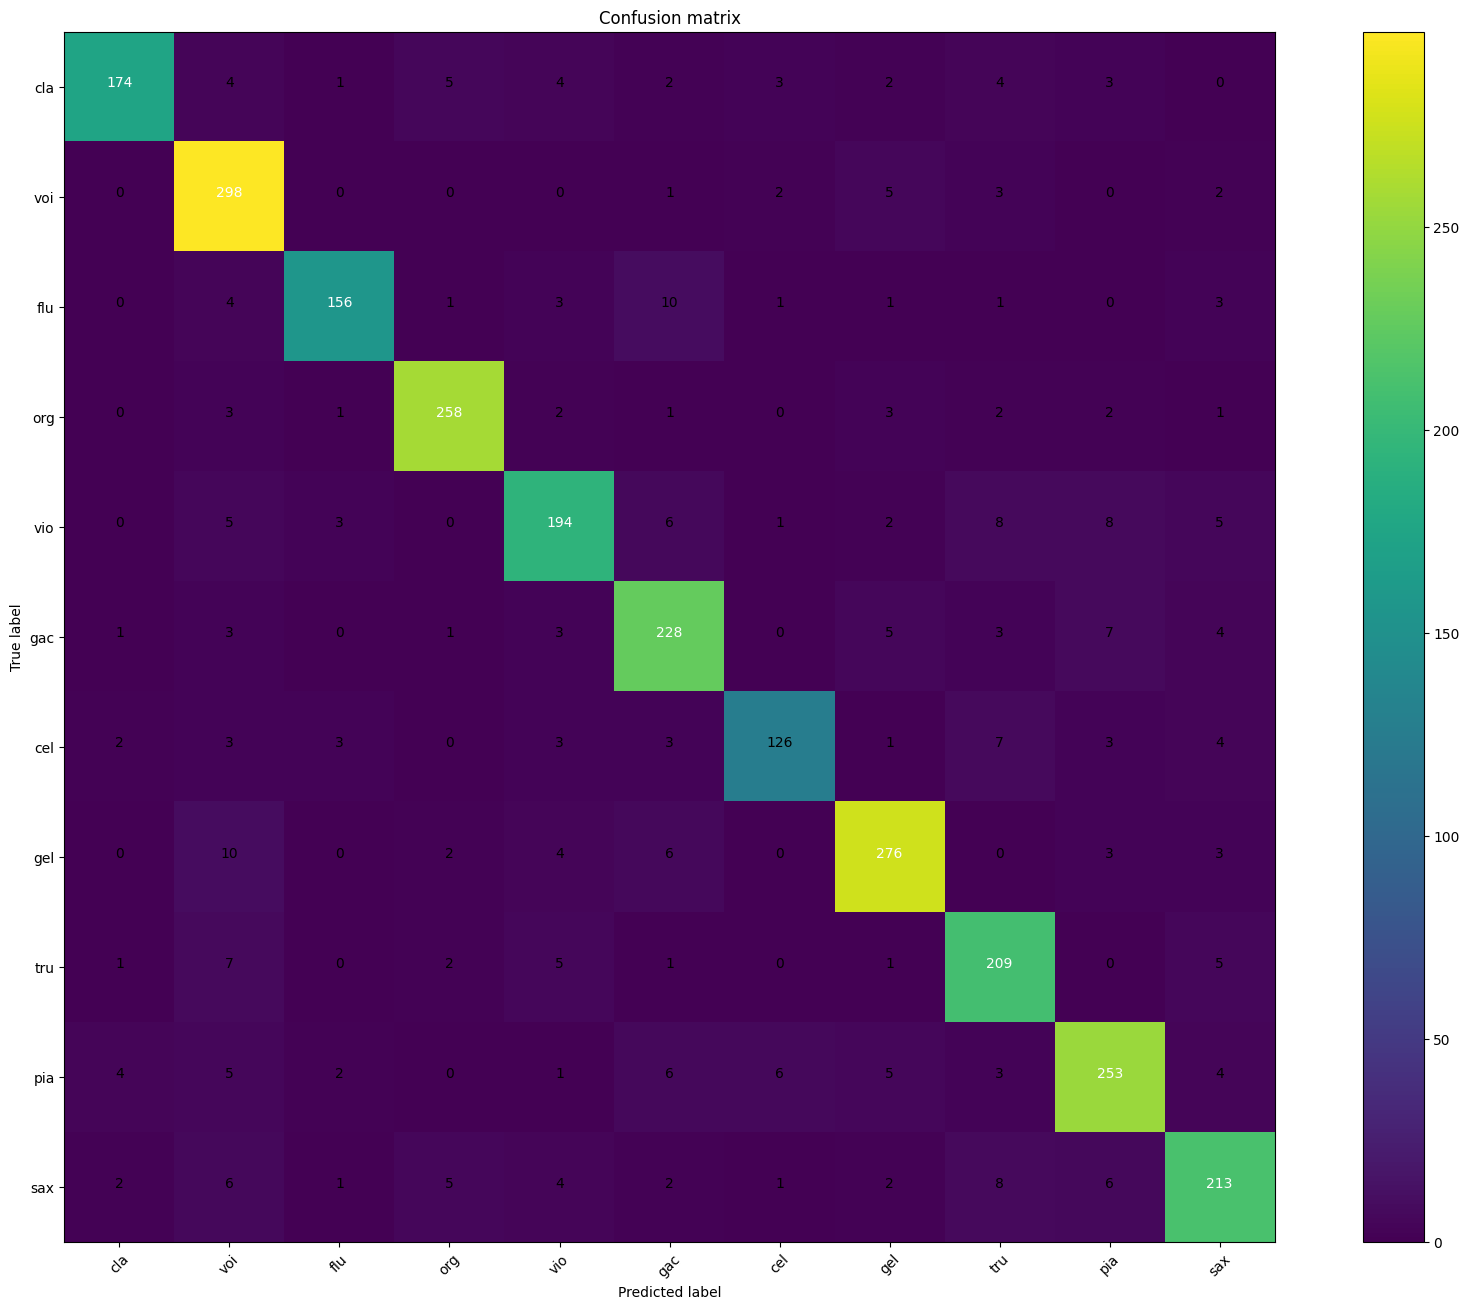

In [165]:

import itertools
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cf, classes=folders,
                      title='Confusion matrix')

In [102]:
# KNN Classifier
n_neighbors_=1
model_knn_ = KNeighborsClassifier(n_neighbors=n_neighbors_,weights='distance')


In [103]:


# kNN
model_knn_.fit(train_set_, train_classes_)



KNeighborsClassifier(n_neighbors=1, weights='distance')

In [104]:
predicted_labels_ = model_knn_.predict(test_set_)

In [105]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes_, predicted_labels_,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes_, predicted_labels_,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes_, predicted_labels_, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes_, predicted_labels_,normalize=True), accuracy_score(test_classes_, predicted_labels_,normalize=False) )
print("Number of samples:",test_classes_.shape[0])



Recall:  [0.52970297 0.70096463 0.55555556 0.74725275 0.56896552 0.67058824
 0.57419355 0.70394737 0.6969697  0.55709343 0.548     ]
Precision:  [0.56315789 0.72425249 0.57142857 0.73913043 0.61111111 0.63568773
 0.51149425 0.67936508 0.6969697  0.54208754 0.57563025]
F1-Score:  [0.54591837 0.7124183  0.56338028 0.7431694  0.58928571 0.65267176
 0.54103343 0.6914378  0.6969697  0.54948805 0.56147541]
Accuracy: 0.63  , 1694
Number of samples: 2682


In [106]:
h=pd.DataFrame({'y_true': test_classes_[0:], 'y_pred':predicted_labels_[0:]})

In [107]:
h

,y_true,y_pred
0,0,0
1,6,0
2,10,10
3,9,9
4,3,3
...,...,...
2677,10,10
2678,3,3
2679,9,9
2680,9,9


In [108]:
cf_=confusion_matrix(test_classes_, predicted_labels_)

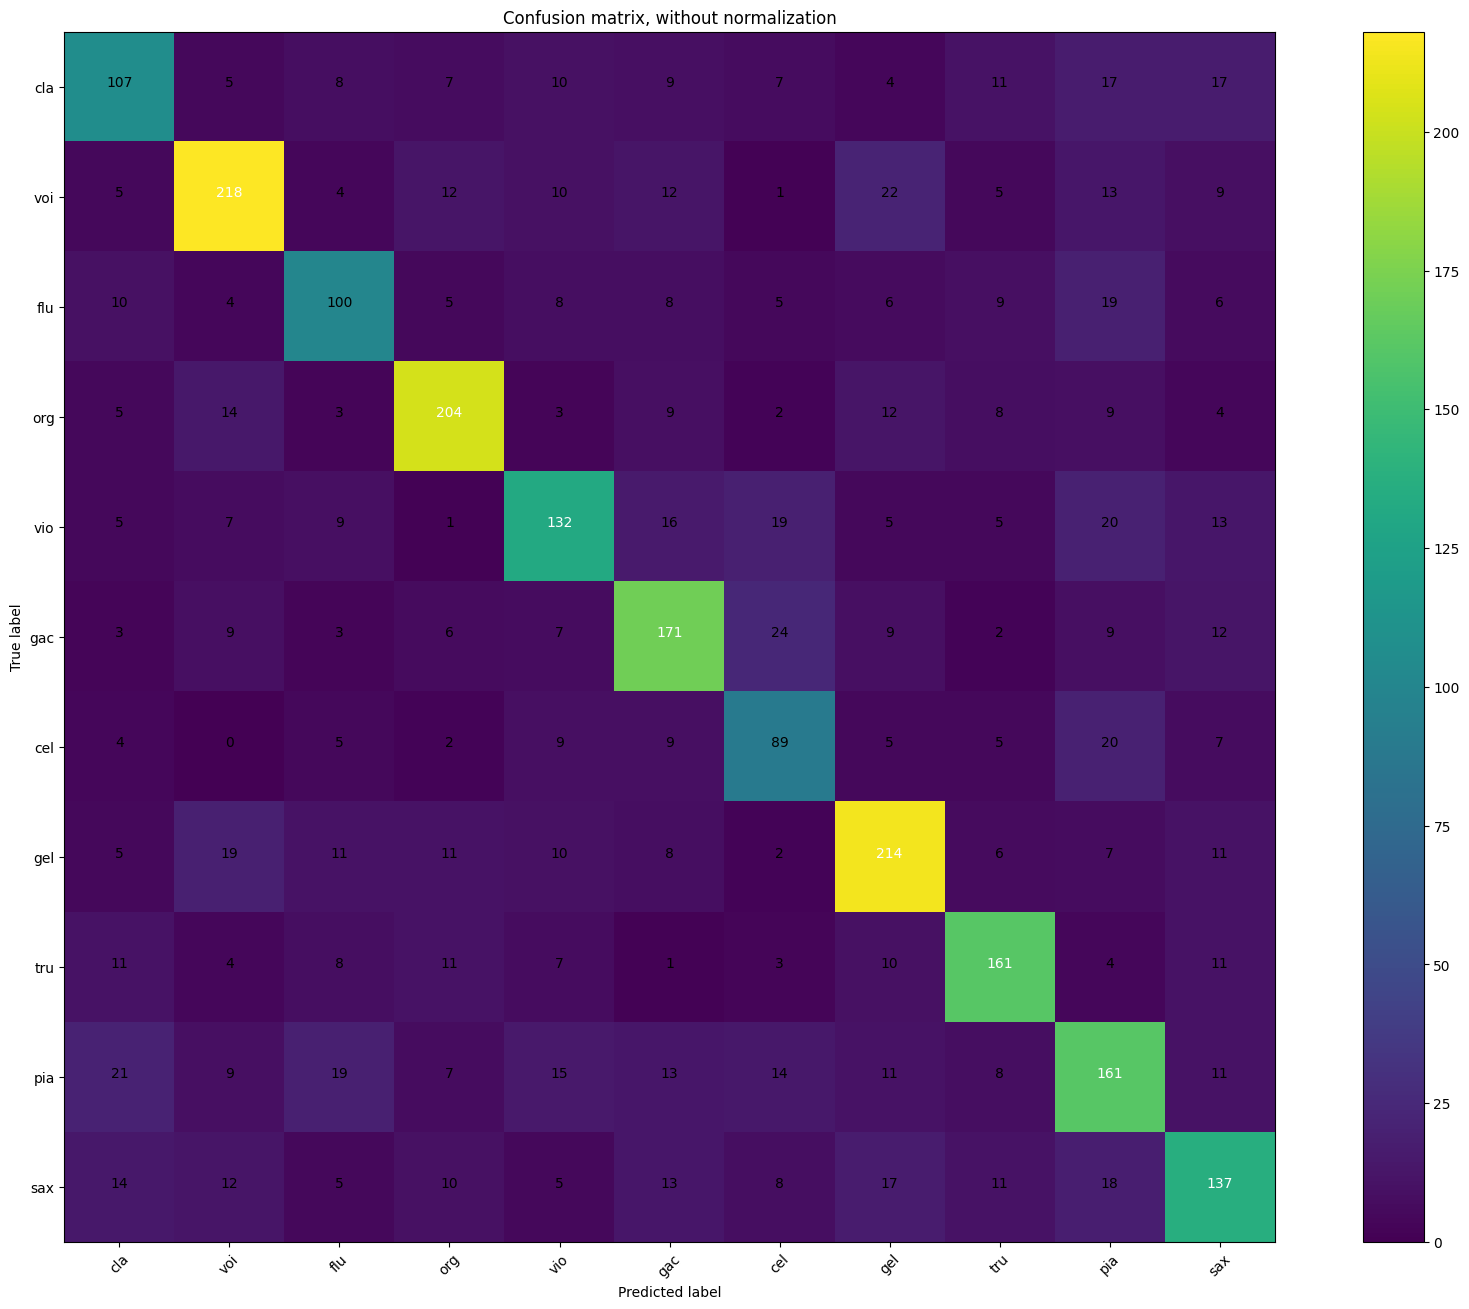

In [109]:

import itertools
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cf_, classes=folders,
                      title='Confusion matrix, without normalization')

In [110]:
joint= np.column_stack([mfcc_scaled,mel_scaled])

In [111]:
joint.shape

(13410, 258)

In [112]:
# Create Train and Test Set
splitter_1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_1= splitter.split(joint,class_set)
for train_index,test_index in splits_1:
    train_set_1 = joint[train_index]
    test_set_1 = joint[test_index]
    train_classes_1 = class_set[train_index]
    test_classes_1= class_set[test_index]

In [113]:
print("train_set shape:",train_set_1.shape)
print("test_set shape:",test_set_1.shape)
print("train_classes shape:",train_classes_1.shape)
print("test_classes shape:",test_classes_1.shape)

train_set shape: (10728, 258)
test_set shape: (2682, 258)
train_classes shape: (10728,)
test_classes shape: (2682,)


In [114]:
# KNN Classifier
n_neighbors=1
model_knn_1 = KNeighborsClassifier(n_neighbors=n_neighbors,weights='uniform')


In [115]:


# kNN
model_knn_1.fit(train_set_1, train_classes_1)



KNeighborsClassifier(n_neighbors=1)

In [116]:
predicted_labels_1 = model_knn_1.predict(test_set_1)

In [117]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes_1, predicted_labels_1,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes_1, predicted_labels_1,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes_1, predicted_labels_1, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes_1, predicted_labels_1,normalize=True), accuracy_score(test_classes_1, predicted_labels_1,normalize=False) )
print("Number of samples:",test_classes_1.shape[0])



Recall:  [0.83168317 0.91961415 0.83333333 0.93772894 0.83189655 0.90196078
 0.81935484 0.875      0.87878788 0.87543253 0.848     ]
Precision:  [0.90322581 0.84365782 0.9202454  0.93772894 0.83549784 0.86466165
 0.88194444 0.8807947  0.86752137 0.85472973 0.85483871]
F1-Score:  [0.86597938 0.88       0.87463557 0.93772894 0.8336933  0.88291747
 0.84949833 0.87788779 0.87311828 0.86495726 0.85140562]
Accuracy: 0.87  , 2344
Number of samples: 2682


In [118]:
u=pd.DataFrame({'y_true': test_classes_1[0:], 'y_pred':predicted_labels_1[0:]})

In [119]:
u

,y_true,y_pred
0,0,0
1,6,6
2,10,10
3,9,9
4,3,3
...,...,...
2677,10,10
2678,3,3
2679,9,9
2680,9,9


In [120]:
cf_1=confusion_matrix(test_classes_1, predicted_labels_1)

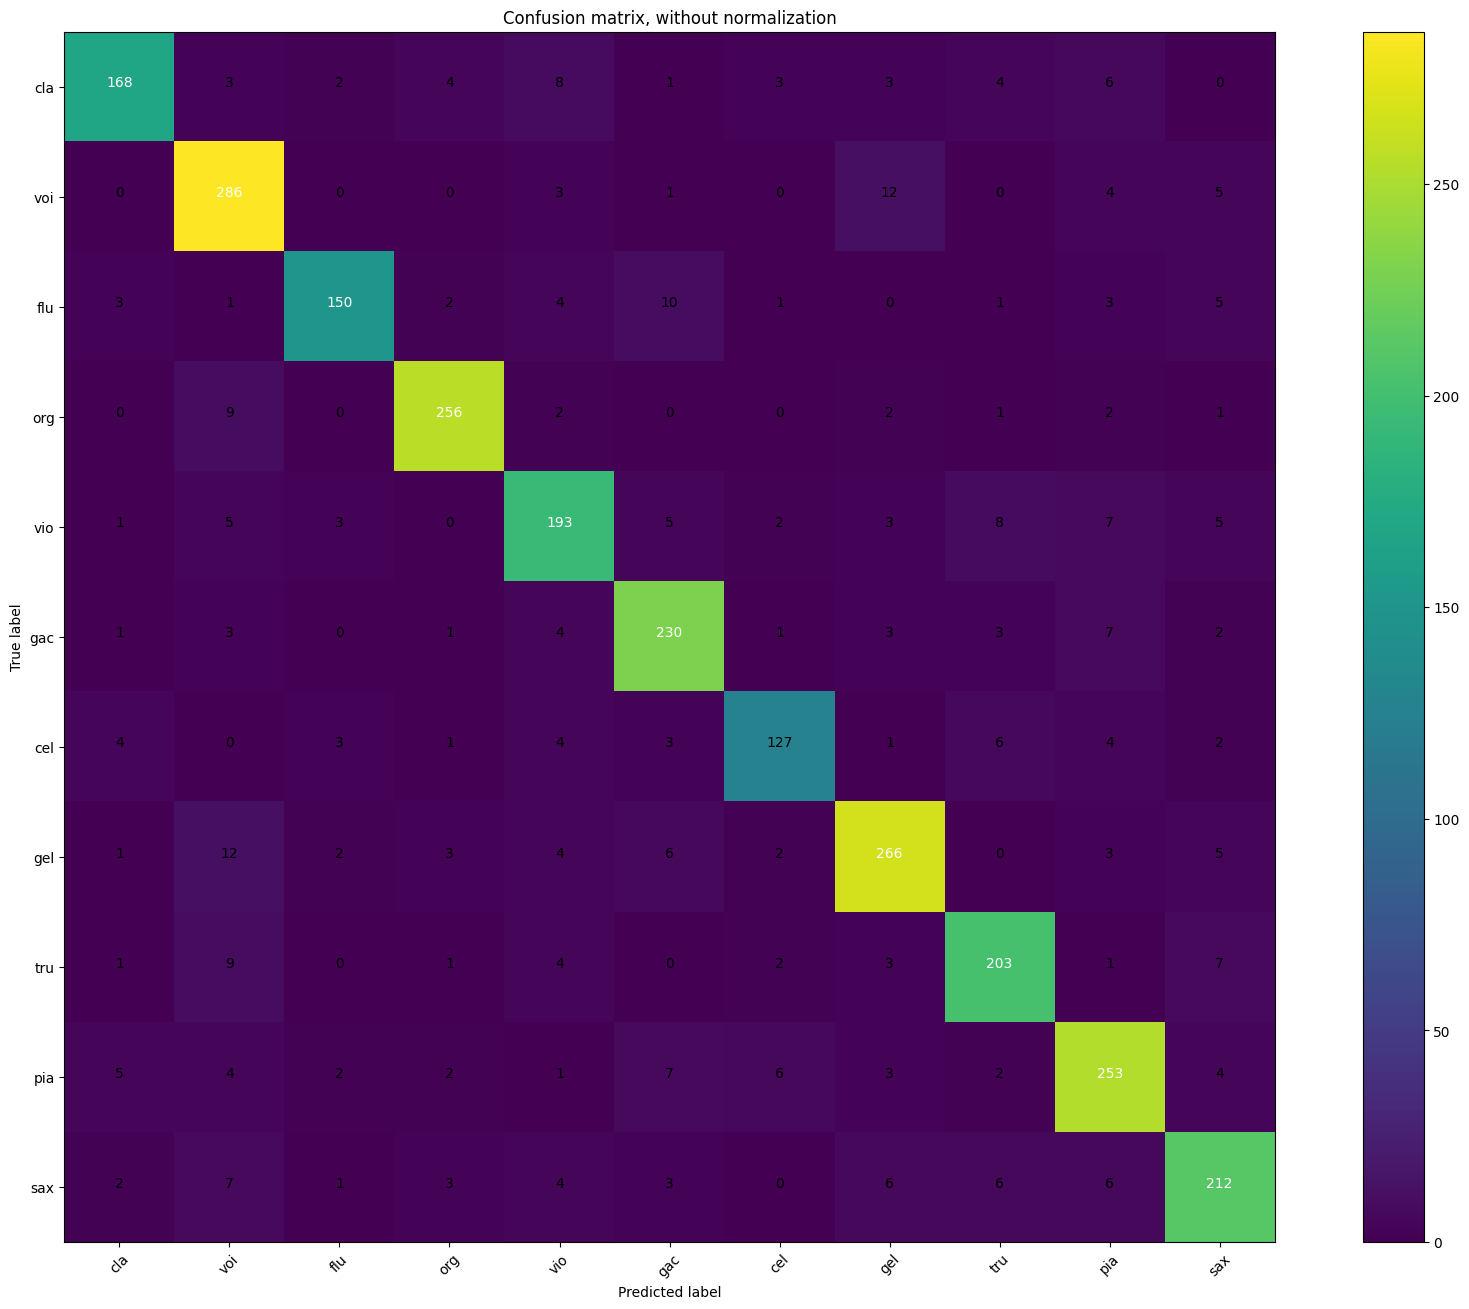

In [121]:

import itertools
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cf_1, classes=folders,
                      title='Confusion matrix, without normalization')

In [122]:
# Create Train and Test Set
splitter_svm = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_svm= splitter_svm.split(joint,class_set)
for train_index,test_index in splits_svm:
    train_set_svm = joint[train_index]
    test_set_svm = joint[test_index]
    train_classes_svm = class_set[train_index]
    test_classes_svm = class_set[test_index]

In [123]:
# Check Set Shapes
print("train_set shape:",train_set_svm.shape)
print("test_set shape:",test_set_svm.shape)
print("train_classes shape:",train_classes_svm.shape)
print("test_classes shape:",test_classes_svm.shape)

train_set shape: (10728, 258)
test_set shape: (2682, 258)
train_classes shape: (10728,)
test_classes shape: (2682,)


In [124]:
from sklearn.svm import LinearSVC, SVC
model_svm = SVC(kernel='poly', degree=1, C=1) 

In [125]:
model_svm.fit(train_set_svm, train_classes_svm)

SVC(C=1, degree=1, kernel='poly')

In [126]:
predicted_svm = model_svm.predict(test_set_svm)

In [127]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes_svm, predicted_svm,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes_svm, predicted_svm,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes_svm, predicted_svm, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes_svm, predicted_svm,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes_svm.shape[0])



Recall:  [0.49009901 0.60128617 0.29444444 0.73260073 0.43534483 0.69019608
 0.35483871 0.58223684 0.46753247 0.70934256 0.328     ]
Precision:  [0.55307263 0.49866667 0.51960784 0.56980057 0.52604167 0.54658385
 0.57894737 0.51453488 0.58378378 0.59766764 0.42268041]
F1-Score:  [0.51968504 0.5451895  0.37588652 0.64102564 0.47641509 0.61005199
 0.44       0.5462963  0.51923077 0.64873418 0.36936937]
Accuracy: 0.54  , 2385
Number of samples: 2682


In [128]:
o=pd.DataFrame({'y_true': test_classes_svm[0:], 'y_pred':predicted_svm[0:]})

In [129]:
o

,y_true,y_pred
0,0,0
1,6,4
2,10,10
3,9,9
4,3,6
...,...,...
2677,10,10
2678,3,3
2679,9,9
2680,9,3


In [130]:
cf_svm=confusion_matrix(test_classes_svm, predicted_svm)

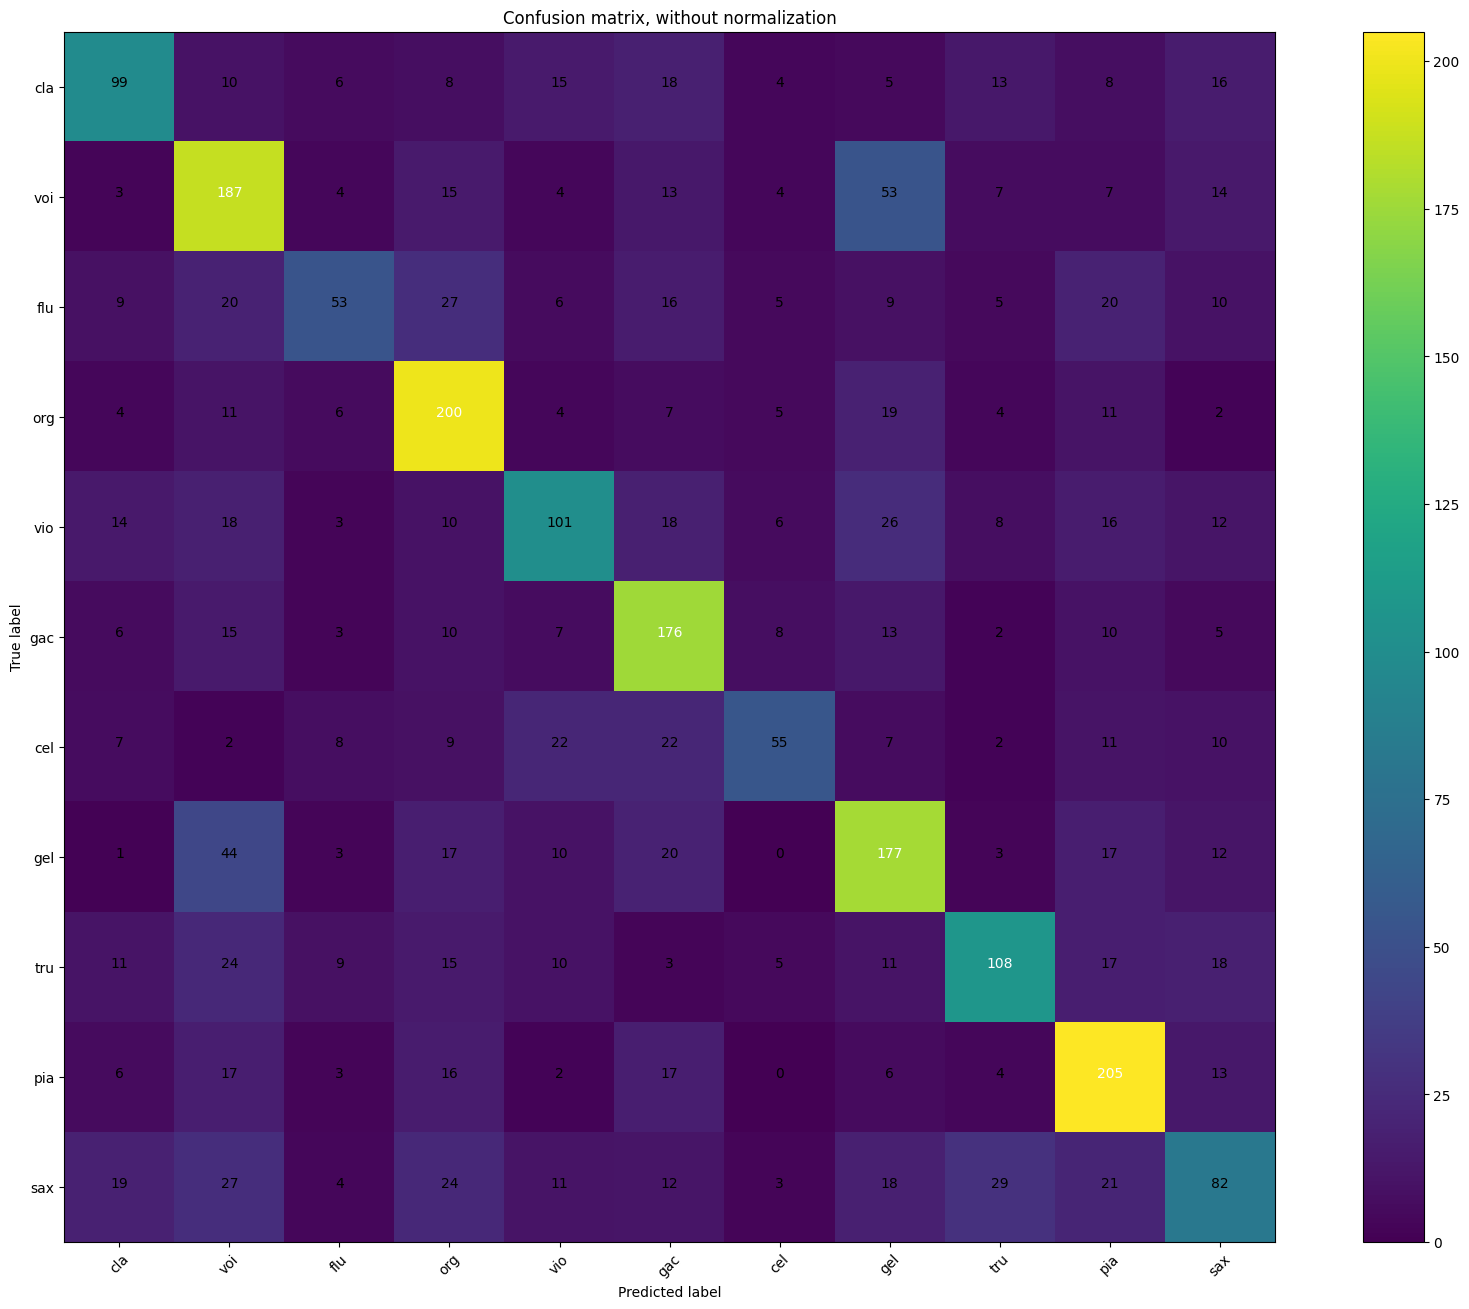

In [131]:

import itertools
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cf_svm, classes=folders,
                      title='Confusion matrix, without normalization')

In [132]:
import pickle
with open('../pages/model_knn_mfcc.pkl', 'wb') as file_out:
    pickle.dump(model_knn, file_out)

In [133]:
with open('../pages/model_knn_mel.pkl', 'wb') as file_out:
    pickle.dump(model_knn_, file_out)

In [134]:
with open('../pages/model_knn_join.pkl', 'wb') as file_out:
    pickle.dump(model_knn_1, file_out)

In [135]:
with open('../pages/svm_join.pkl', 'wb') as file_out:
    pickle.dump(model_svm, file_out)

In [136]:
with open('../pages/scaler_mfcc.pkl', 'wb') as file_out:
    pickle.dump(scaler_mfcc, file_out)

In [137]:
with open('../pages/scaler_mel.pkl', 'wb') as file_out:
    pickle.dump(scaler_mel, file_out)

In [138]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
y_,sr=librosa.load('../../../../mir_datasets/irmas/IRMAS-TrainingData/pia/001__[pia][nod][cla]1389__1.wav',sr=44100)
# trying a piano audio file

In [139]:
X_ = librosa.feature.melspectrogram(y=y_,sr=44100,n_fft=2048,hop_length=512,n_mels=129)

In [140]:
X_mean_=np.mean(X_,1)

In [141]:
X_mean_resh=X_mean_.reshape(1,-1)

In [142]:
X_mel_scaled=scaler_mel.transform(X_mean_resh)

In [143]:
X_.shape,X_mean_.shape,X_mean_resh.shape,X_mel_scaled.shape

((129, 259), (129,), (1, 129), (1, 129))

In [144]:
X_mfcc=librosa.feature.mfcc(S=librosa.power_to_db(X_),n_mfcc=129)

In [145]:
X_mfcc_=np.mean(X_mfcc,1)

In [146]:
p=X_mfcc_.reshape([1,-1])

In [147]:
X_mfcc_scaled=scaler_mfcc.transform(p)

In [148]:
X_mfcc_[0],p[0][0]

(-426.8358, -426.8358)

In [149]:
X_mfcc.shape, X_mfcc_.shape,p.shape

((129, 259), (129,), (1, 129))

In [150]:
scaled=np.column_stack([X_mfcc_scaled,X_mel_scaled])

In [151]:
model_knn.predict(X_mfcc_scaled)

array([9])

In [152]:
model_knn_.predict(X_mel_scaled)

array([9])

In [153]:
model_knn_1.predict(scaled)

array([9])

In [154]:
model_svm.predict(scaled)

array([4])